In [1684]:
# import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

In [1685]:
# using LinearAlgebra
# using PyPlot

In [1686]:
# IHLQR
function backward_pass!(A,B,f,Q,q,R,r,P,p,K,d)
    Kinf_ = 0.0
    Pinf_ = 1*P[:,:,N]
    # IHLQR
    for k = (500):-1:1
        # print(Pinf_, "\n")
        Kinf_ = (R + B'*Pinf_*B)\(B'*Pinf_*A)
        Pinf_ = Q + Kinf_'*R*Kinf_ + (A-B*Kinf_)'*Pinf_*(A-B*Kinf_)
    end
    P[:,:,1] .= Pinf_
    K[:,:,1] .= Kinf_
end

function compute_linear_cost!(q, r, p, Q, R, xref, uref)
    # compute linear cost terms
    for k = (N-1):-1:1
        q[:,k] .= -Q*xref[:,k]
        r[:,k] .= -R*uref[:,k]
    end
    q[:,N] .= -Q*xref[:,N]
    p[:,N] .= -Pinf*xref[:,N] # important
end

#ADMM Functions
# function backward_pass!(A,B,f,Q,q,R,r,P,p,K,d)
#     #This is the standard Riccati backward pass with both linear and quadratic terms (like iLQR)
#     for k = (N-1):-1:1
#         q[:,k] .= -Q*xref[:,k]
#         K[:,:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*P[:,:,k+1]*A)
#         d[:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*p[:,k+1] + B'*P[:,:,k+1]*f + r[:,k])
#         r[:,k] .= -R*uref[:,k]
#         P[:,:,k] .= Q + 1*K[:,:,k]'*R*K[:,:,k] + (A-1*B*K[:,:,k])'*P[:,:,k+1]*(A-B*K[:,:,k])
#         # p[:,k] .= q[:,k] + (A-B*K[:,:,k])'*(p[:,k+1]-P[:,:,k+1]*B*d[:,k]) + K[:,:,k]'*(R*d[:,k]-r[:,k])
#         p[:,k] .= q[:,k] + (A-B*K[:,:,k])'*p[:,k+1] - K[:,:,k]'*r[:,k] + (A-B*K[:,:,k])'*P[:,:,k+1]*f
#     end
# end

######################################################################
# Terminal cost + IHLQR helps with convergence to the original problem
######################################################################

function backward_pass_grad!(A,B,f,q,R,r,P,p,K,d)
    #This is just the linear/gradient term from the backward pass (no cost-to-go Hessian or K calculations)
    for k = (N-1):-1:1
        d[:,k] .= Quu_inv*(B'*p[:,k+1] + r[:,k] + BPf)
        p[:,k] .= q[:,k] + AmBKt*p[:,k+1] - Kinf'*r[:,k] + APf
    end
end

# function backward_pass_grad!(A,B,f,q,R,r,P,p,K,m)
#     #This is just the linear/gradient term from the backward pass (no cost-to-go Hessian or K calculations)
#     for k = (N-1):-1:1
#         d[:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*p[:,k+1] + B'*P[:,:,k+1]*f + r[:,k])
#         p[:,k] .= q[:,k] + (A-B*K[:,:,k])'*p[:,k+1] - K[:,:,k]'*r[:,k] + (A-B*K[:,:,k])'*P[:,:,k+1]*f
#     end
# end

# function forward_pass!(A,B,f,K,d,x,u)
#     for k = 1:(N-1)
#         u[:,k] .= -K[:,:,k]*(x[:,k]-0*xref[:,k]) - d[:,k] + 0*uref[:,k]
#         x[:,k+1] .= A*x[:,k] + B*u[:,k] + f
#     end
# end

function forward_pass!(A,B,f,K,d,x,u)
    for k = 1:(N-1)
        u[:,k] .= -Kinf*x[:,k] - d[:,k]
        x[:,k+1] .= A*x[:,k] + B*u[:,k] + f
    end
end

function update_primal!(A,B,f,q,R̃,r,P,p,K,d,x,u)
    backward_pass_grad!(A,B,f,q,R̃,r,P,p,K,d)
    # backward_pass!(A,B,f,Q,q,R̃,r,P,p,K,d)
    forward_pass!(A,B,f,K,d,x,u)
end
function update_slack!(u,z,y)
    #This function clamps the controls to be within the bounds
    for k = 1:(N-1)
        z[:,k] .= min.(umax, max.(umin, u[:,k]+y[:,k]))
    end
end

function update_dual!(u,z,y)
    #This function performs the standard AL multiplier update.
    #Note that we're using the "scaled form" where y = λ/ρ
    for k = 1:(N-1)
        y[:,k] .= y[:,k] + u[:,k] - z[:,k]
    end
end

function update_linear_cost!(z,y,r)
    #This function updates the linear term in the control cost to handle the changing cost term from ADMM
    for k = 1:(N-1)
        r[:,k] .= -ρ*(z[:,k]-y[:,k])
    end
end

update_linear_cost! (generic function with 1 method)

In [1687]:
#Rocket landing
h = 0.05
nx = 6
nu = 3
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905] * 1

6-element Vector{Float64}:
  0.0
  0.0
 -0.0122625
  0.0
  0.0
 -0.4905

In [1688]:
#Reference state trajectory to track (origin)
N = 301
t = h*(0:N-1)
xref = zeros(nx,N)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
for k = 1:N
  xref[:,k] = x0 + (xg - x0)*(k-1)/(N-1)
end
#Reference input trajectory
uref = repeat([0; 0; 10.0], 1, N-1)

3×300 Matrix{Float64}:
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 10.0  10.0  10.0  10.0  10.0  10.0     10.0  10.0  10.0  10.0  10.0  10.0

In [1689]:
#Cost Function
# J = Σ 0.5*(x-xref)'*Q*(x-xref) + 0.5*(u-uref)*R*(u-uref) + 0.5*xn'*Qn*xn
Q = 1e2*I(nx)
R = 1e0*I(nu)
# Qn = 1e3*I(nx)

q = zeros(6,N)
r = zeros(3,N-1)

3×300 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [1690]:
#Control Bounds
umin = -10.0*ones(nu)
umax =  105.0*ones(nu)

3-element Vector{Float64}:
 105.0
 105.0
 105.0

In [1691]:
#Algorithm Setup

x = zeros(nx,N)
x[:,1] .= x0
u = repeat([0; 0; 10.0], 1, N-1)

ρ = 1e-1
R̃ = R + 1*ρ*I

P = zeros(nx,nx,N)
P[:,:,N] .= Q
p = zeros(nx,N)
p[:,N] .= -P[:,:,N]*xref[:,N]  #q[:,N]

K = zeros(nu,nx,N-1)
d = zeros(nu,N-1)

z = zeros(nu,N-1);
znew = zeros(nu,N-1);
y = zeros(nu,N-1);

# compute terminal cost-to-go for mpc
# backward_pass!(A,B,f,Q,q,R,r,P,p,K,d)
# P[:,:,N] = 1*P[:,:,1]

# compute IHLQR preconditioner
backward_pass!(A,B,f,Q,q,R̃,r,P,p,K,d)
Pinf = 1*P[:,:,1]
Kinf = 1*K[:,:,1]
Quu_inv = (R̃ + B'*Pinf*B)\I
AmBKt = (A-B*Kinf)'
BPf = B'*Pinf*f
APf = AmBKt*Pinf*f

6-element Vector{Float64}:
     0.0
     0.0
  -986.6142310671671
     0.0
     0.0
 -1761.4535118570152

In [1692]:
display(BPf)
N

3-element Vector{Float64}:
  0.0
  0.0
 -9.443930928862892

301

In [1693]:
#Main algorithm loop

# I count this as one iteration by including it into the for loop
compute_linear_cost!(q, r, p, Q, R̃, xref, uref)
forward_pass!(A,B,f,K,d,x,u)
update_slack!(u,z,y)
update_dual!(u,z,y)
update_linear_cost!(z,y,r)

iter = 0
primal_residual = 1.0
dual_residual = 1.0
for k = 1:500
    update_primal!(A,B,f,q,R̃,r,P,p,K,d,x,u)
    update_slack!(u,znew,y)
    update_dual!(u,znew,y)
    update_linear_cost!(znew,y,r)
    
    primal_residual = maximum(abs.(u-z))
    dual_residual = maximum(abs.(ρ*(znew-z)))
    if (primal_residual < 0.01 && dual_residual < 0.01)
        break
    end

    z .= znew
    iter += 1
end

In [1694]:
iter

500

In [1695]:
# Kinf = zeros(nu, nx)
# P = 1*Q
# for ricatti_iter = 1:100
#     Kinf = (R + B' * P * B) \ (B' * P * A)
#     P = Q + A' * P * (A - B * Kinf)
# end    
# # TODO: simulate this controlled system with rk4(params_real, ...)
# for k = 1:(N-1)
#     u[:,k] .= -0.01*Kinf*(x[:,k]-1*xref[:,k]) 
#     x[:,k+1] .= A*x[:,k] + B*u[:,k]
# end

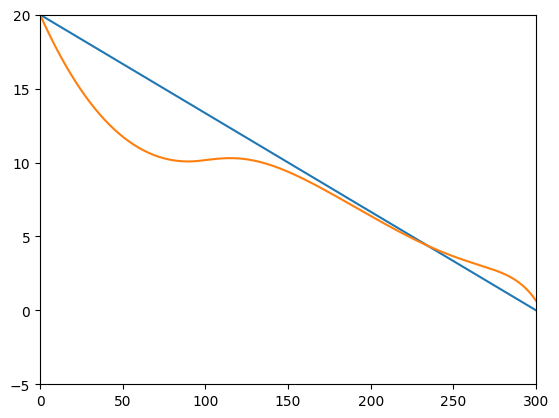

In [1696]:
fig = plt.figure()
plot(xref[3,:]) # z
plot(x[3,:])
# put limit on axis
plt.ylim(-5, 20)
plt.xlim(0, 300)
fig

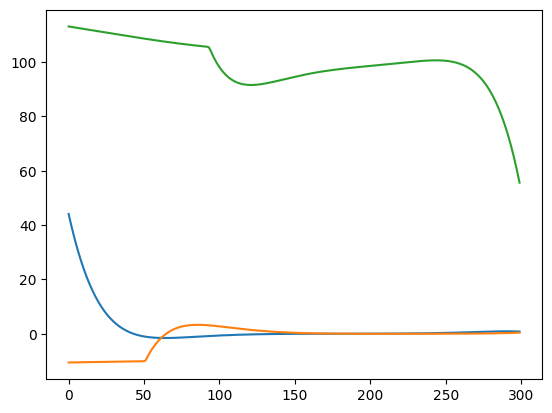

In [1697]:
fig = plt.figure()
plot(u[1,:])
plot(u[2,:])
plot(u[3,:])
fig

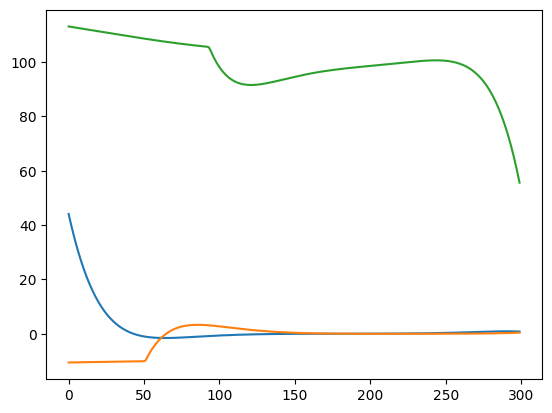

In [1698]:
fig = plt.figure()
plot(u[1,:])
plot(u[2,:])
plot(u[3,:])
fig

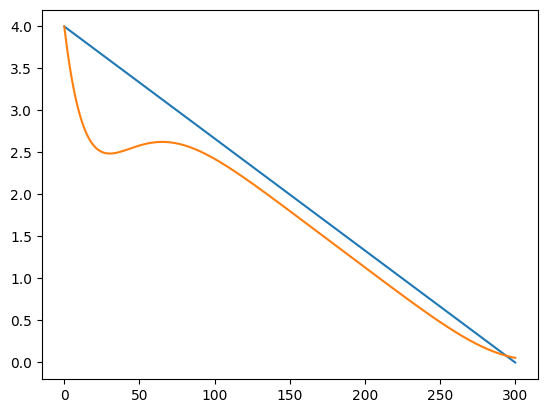

In [1699]:
fig = plt.figure()
plot(xref[1,:])
plot(x[1,:]+0*xref[1,:])
fig

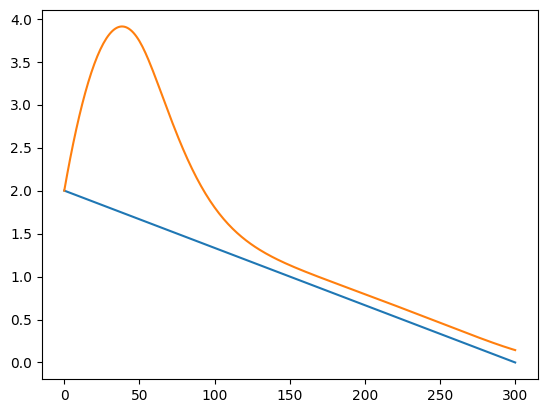

In [1700]:
fig = plt.figure()
plot(xref[2,:])
plot(x[2,:]+0*xref[2,:])
fig

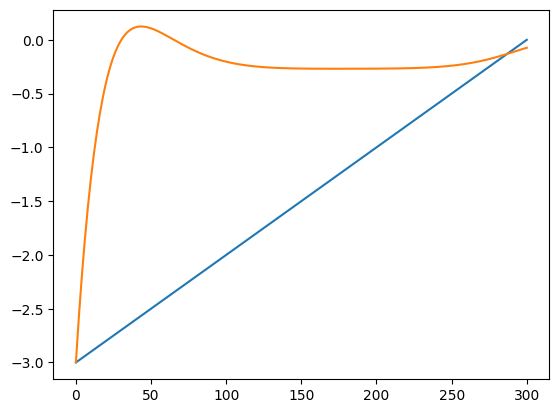

In [1701]:
fig = plt.figure()
plot(xref[4,:])
plot(x[4,:]+0*xref[4,:])
fig

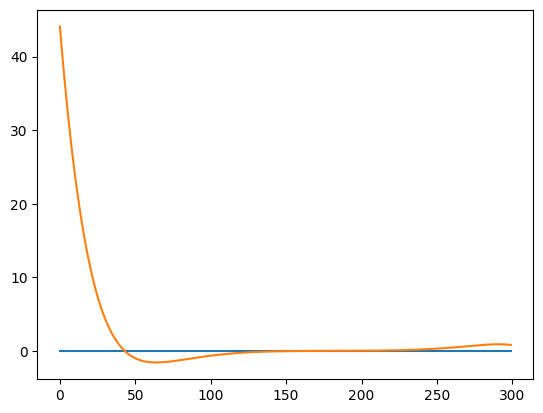

In [1702]:
fig = plt.figure()
plot(uref[1,:])
plot(u[1,:])
fig

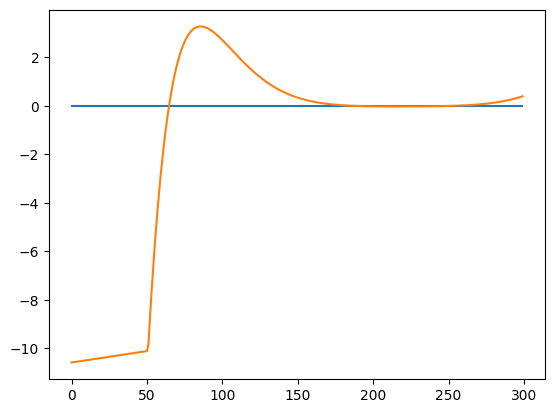

In [1703]:
fig = plt.figure()
plot(uref[2,:])
plot(u[2,:])
fig

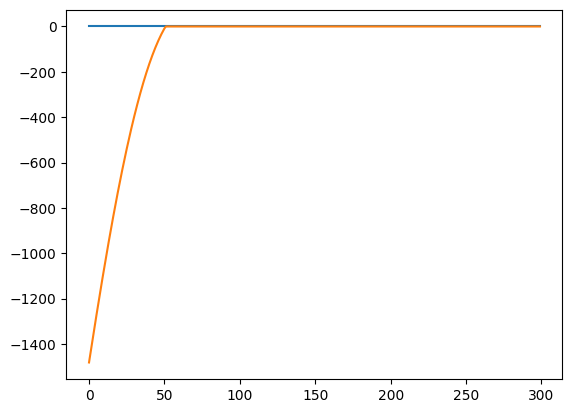

In [1704]:
fig = plt.figure()
plot(y[1,:])
plot(y[2,:])
fig

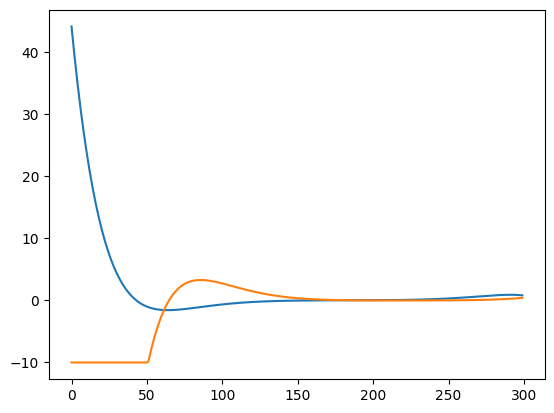

In [1705]:
fig = plt.figure()
plot(z[1,:])
plot(z[2,:])
fig